In [1]:
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
## Loading data
from torchvision import datasets
from torchvision.transforms import ToTensor

# pytorch has several datasets you can download, including the MNIST hand writen digit
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)


In [3]:
## save MNIST data as numpy arrays
# imgs = train_data.data.detach().numpy()
# labels = train_data.targets.detach().numpy()
# np.savez('MNIST_train.npz',imgs=imgs,labels=labels)

# imgs = test_data.data.detach().numpy()
# labels = test_data.targets.detach().numpy()
# np.savez('MNIST_test.npz',imgs=imgs,labels=labels)

# alternative: loading from disk
# data = np.load('MNIST_train.npz')
# imgs=torch.from_numpy(data['imgs']).to(torch.float32) # convert to torch tensor with dtype float32 (must match the model dtype)
# labels=data['labels']
# train_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

# data = np.load('MNIST_test.npz')
# imgs=torch.from_numpy(data['imgs']).to(torch.float32)
# labels=data['labels']
# test_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
5
torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

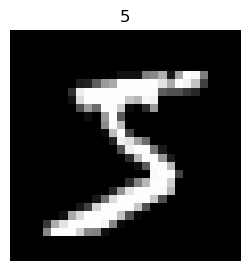

In [4]:
# plot your loaded data
import matplotlib.pyplot as plt

print(train_data)
print(test_data)

img, label = train_data[0]
print(label)
print(img.shape)

figure = plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis("off")


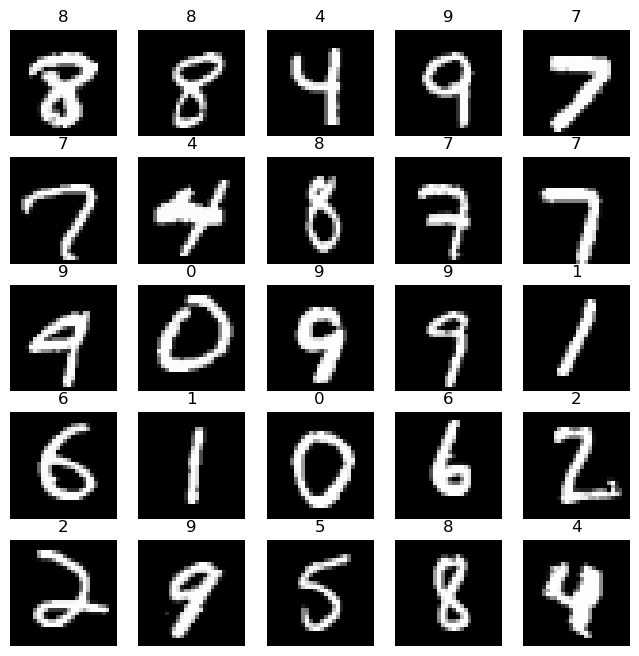

In [5]:
# setup Data loader 

batchsize = 32

from torch.utils.data import DataLoader
loaders = { # library of dataloader functions
    'train' : DataLoader(train_data, 
                                          batch_size=batchsize, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : DataLoader(test_data, 
                                          batch_size=batchsize, 
                                          shuffle=True, 
                                          num_workers=1),
}
img,label=next(iter(loaders['train']))

import plot_examples 
plot_examples.plot(img,label,[])

In [6]:
from torchsummary import summary
import DFF # try DFF
from importlib import reload  # Python 3.4+
reload(DFF) # try DFF

net = DFF.Net().to(device)
summary(net, (1,1,28,28))

loss_train=[] # loss collector
loss_test=[]


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 196]                 153,860
├─Linear: 1-2                            [-1, 49]                  9,653
├─Linear: 1-3                            [-1, 10]                  500
Total params: 164,013
Trainable params: 164,013
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.63


In [7]:
# Some standard imports
import torch.onnx

img,label=next(iter(loaders['train'])) # get a batch
torch.onnx.export(net,img.to(device),'MNIST_DFF.onnx',export_params=True,input_names = ['image'],output_names = ['label'],
                  dynamic_axes={'image' : {0 : 'batch_size'},'label' : {0 : 'batch_size'}}) 
# load file into https://netron.app/

In [8]:
# setup training routine
from torch import optim
from torch import nn
from torch import optim

# Loss function
loss = nn.CrossEntropyLoss()
# loss = nn.MSELoss() # would need to convert label to onhotvector -> nn.functional.one_hot(label,num_classes=10)

# accuracy
def accuracy_calc(labels,labels_pred_int):
    labels = labels.cpu().detach().numpy()
    labels_pred_int = labels_pred_int.cpu().detach().numpy()
    return 100*(labels_pred_int == labels).sum().item() / np.shape(labels)[0]

# optimizer
lr = 0.01
momentum = 0 # try 0.5
optimizer = optim.SGD(net.parameters(),momentum=momentum,lr=lr) # stocastic gradient decent
# optimizer = optim.Adam(net.parameters(),weight_decay=0,lr=lr) # more advanced alternative


# def training step
def run_model(img,labels,model,optimizer,Loss,train=False):
    if train: # only important in specific instances (e.g. if your model has dropout layers or variational layers)
        model.train()
    else:
        model.eval()
    
    optimizer.zero_grad() # othewise gradients will accumulate

    labels_pred = model(img)  # run model
    labels_pred_int = labels_pred.argmax(axis=1)
    loss = Loss(labels_pred,labels) # only uses one channel
    accuracy = accuracy_calc(labels,labels_pred_int)

    if train:
        # backprob and update
        loss.backward()
        optimizer.step()
    
    return loss, labels_pred, labels_pred_int, accuracy



In [9]:
# check its all working
img,label=next(iter(loaders['train'])) # get a batch
img = img.to(device)
label = label.to(device)
batch_loss, label_pred, label_pred_int, accuracy = run_model(img,label,net,optimizer,loss)

label=label.cpu().detach().numpy()
batch_loss=batch_loss.cpu().detach().numpy()
label_pred=label_pred.cpu().detach().numpy()
label_pred_int=label_pred_int.cpu().detach().numpy()

print('label:            ' + np.array2string(label))
print('label prediction: ' + np.array2string(label_pred_int))
print('label weights first example: ' + np.array2string(label_pred[0]*100,precision=0,suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(accuracy) + '%')


label:            [8 4 7 9 5 6 7 1 5 0 8 0 3 9 0 6 8 1 0 0 4 4 3 0 3 7 0 6 5 7 9 9]
label prediction: [7 5 5 5 7 7 7 7 5 5 7 5 7 5 7 5 7 5 7 5 7 7 7 7 5 5 7 7 5 5 5 7]
label weights first example: [10.  9. 11. 10. 10. 11.  9. 11. 10.  9.]
loss: 2.303102
accuracy: 9.375%


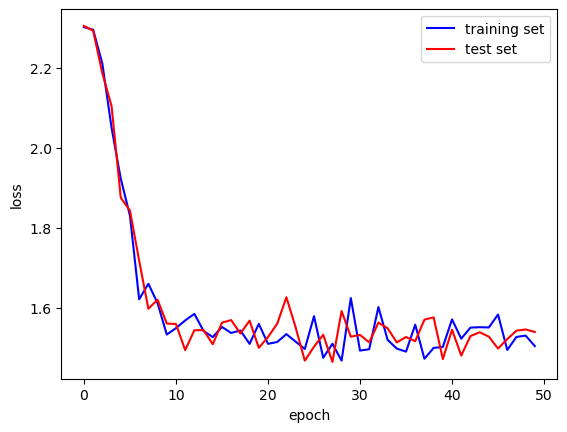

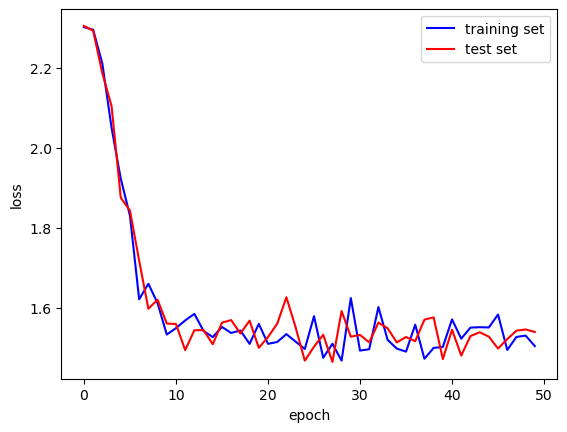

In [10]:
from tqdm import tqdm
from IPython import display

# training loop
epochs = 50 # 
plot_itn = 1 # plot every few epochs


plt.figure()
for ep_n in range(epochs):

    if len(loss_train)<1: # if no training has happened yet save initial loss value
        img,label=next(iter(loaders['train'])) # get a batch
        img = img.to(device)
        label = label.to(device)
        batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
        loss_train.append(batch_loss.cpu().detach().numpy())

    if len(loss_test)<1: # if no training has happened yet save initial loss value
        img,label=next(iter(loaders['test'])) # get a batch
        img = img.to(device)
        label = label.to(device)
        batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
        loss_test.append(batch_loss.cpu().detach().numpy())

    for img,label in tqdm(loaders['train']):
        img = img.to(device)
        label = label.to(device)
        net.train()
        run_model(img,label,net,optimizer,loss,train=True)

    # train set loss
    img,label=next(iter(loaders['train'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_train.append(batch_loss.cpu().detach().numpy())

    # test set loss
    img,label=next(iter(loaders['test'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img,label,net,optimizer,loss)
    loss_test.append(batch_loss.cpu().detach().numpy())

    if (ep_n % plot_itn)==0:
        plt.clf()
        train_handle = plt.plot(loss_train[0:-1], color='blue',label='training set')
        test_handle = plt.plot(loss_test[0:-1], color='red',label='test set')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    

label: [9 8 4 9 5 0 0 6 7 0 3 4 4 4 5 0 6 9 3 0 0 0 0 1 1 3 7 0 2 4 0]
label prediction: [9 8 4 9 5 6 0 6 7 0 3 4 4 4 5 0 6 4 3 0 0 0 0 1 1 3 7 0 2 4 0]
label weights first example: [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.]
loss: 1.4881389
accuracy: 97.73%


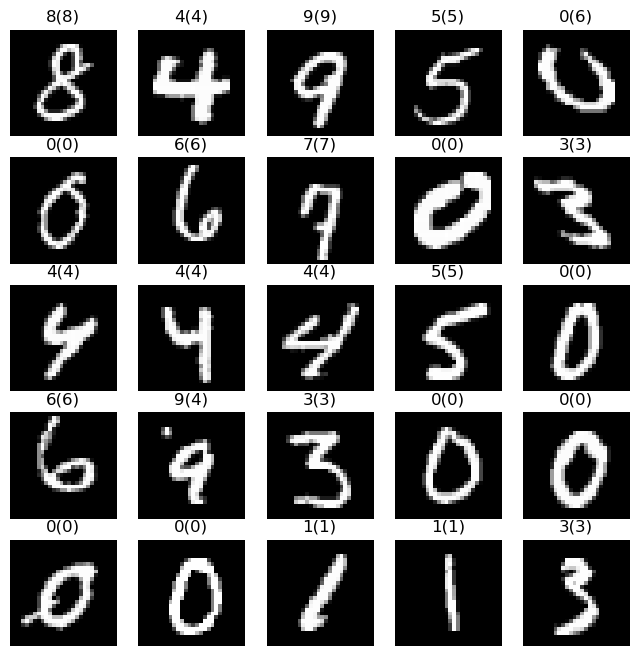

In [20]:
# check its all working
loader_temp = iter(loaders['test'])
img,label = next(loader_temp) # get a batch
for i in range(10): # get multiple batches to get more accurate estimates
    img_temp, label_temp = next(loader_temp)
    img=torch.cat((img,img_temp),dim=0)
    label=torch.cat((label,label_temp),dim=0)
img = img.to(device)
label = label.to(device)
batch_loss, label_pred, label_pred_int, accuracy = run_model(img,label,net,optimizer,loss)


img=img.cpu().detach().numpy()
label=label.cpu().detach().numpy()
batch_loss=batch_loss.cpu().detach().numpy()
label_pred=label_pred.cpu().detach().numpy()
label_pred_int=label_pred_int.cpu().detach().numpy()

print('label: ' + np.array2string(label[0:31]))
print('label prediction: ' + np.array2string(label_pred_int[0:31]))
print('label weights first example: ' + np.array2string(label_pred[0]*100,precision=0,suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(round(accuracy, 2)) + '%')

plot_examples.plot(img,label,label_pred_int)

In [12]:
# saveing a model
torch.save(net.state_dict(), '/PytorchTutorial/MNIST_DFF1.pt')


In [13]:
## loading a model

# load model
import DFF # try DFF
net = DFF.Net().to(device)

# load weights into model
net.load_state_dict(torch.load('/PytorchTutorial/MNIST_DFF1.pt'))

<All keys matched successfully>